In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from model import InvertedPendulum
import matplotlib.animation as animation
from functools import partial


In [29]:
class PID_controller():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def action(self, error, errorDot, errorInt):
        return self.kp*error + self.ki*errorInt + self.kd*errorDot
    
class stateFeedback_controller():
    def __init__(self, gain):
        self.gain = gain
    
    def action(self, state):
        return np.dot(self.gain, state)
    
def update(frame, theta_arr, pendCen, pendLen, line): #function for creating animation
    theta = theta_arr[frame]
    x = [pendCen[0], pendCen[0] - pendLen*np.sin(theta)]
    z = [pendCen[1], pendCen[1] - pendLen*np.cos(theta)]
    line.set_xdata(x)
    line.set_ydata(z)
    return line

#supporting function to copute MPC objective
def weightedNorm(v, W):
    if isinstance(W, np.ndarray):
        return np.transpose(v) @ W @ v
    elif isinstance(W, int):
        return v**2*W
    else:
        print('weighting matrix is not valid')
        return None

def mpc_objective(u, model, u_prev, W_inf, W_e, W_delu, x_hat, set_point, pred_hor, con_hor, sim_dt):
    x_hat = x_hat.reshape(2,1)
    Phi, Gamma, C_d = model.getDiscreteDynMatrix(x_hat[0,0], sim_dt)
    #set_point  = set_point - C_d @ x_hat #set point for the purturbed system
    x_hat_init = x_hat 
    x_T = np.array([set_point, 0]).reshape(2,1)
    x_hat = x_T - x_hat
    eps = C_d @ (x_hat)
    cost = weightedNorm(eps, W_e) + weightedNorm((u[0] - u_prev), W_delu)
    i = 0
    u = np.append(u, u[-1] * np.ones(pred_hor - con_hor))
    while i < pred_hor:
        x_hat =  Phi @ x_hat + Gamma * np.array(u[i]) #need to fix this for tackling the case of u[i] being non-scalar
        y_hat = C_d @ x_hat
        eps = 0 - y_hat
        if i == pred_hor - 1: 
            break #to compute eps for terminal cost in the same loop
        cost += weightedNorm(eps, W_e) + weightedNorm((u[i+1] - u[i]), W_delu)
        i += 1
    #adding the terminal cost
    cost += weightedNorm(eps, W_inf)
    return cost
        

In [61]:
m_ivp = 1
k_ivp = 1
l_ivp = 1
g = 9.8
procNoiseCov = 2
mesNoiseCov = 0.2
inverted_pendulum = InvertedPendulum(m_ivp, l_ivp, g, k_ivp, isDisturb_ivp, procNoiseCov, mesNoiseCov)
W_e = 100
W_delu = 2
W_inf = 20
pred_hor = 40
con_hor = 10
ThetaT = 4*np.pi/3
x_hat = np.array([0 ,0])
res = sc.optimize.minimize(mpc_objective, x0 = np.ones(con_hor), args=(inverted_pendulum, 0, W_inf, W_e, W_delu, x_hat, ThetaT, pred_hor, con_hor, 0.05))
print(res.x)

Phi, Gamma, C_d = inverted_pendulum.getDiscreteDynMatrix(x_hat[0], 0.05)
x_sim = np.array([ThetaT, 0]).reshape(2,1) - x_hat.reshape(2,1)

# for i in range(con_hor):
#     x_sim = Phi @ x_sim + Gamma * np.array(res.x[i])
#     y_sim = C_d @ x_sim
#     print(x_sim, y_sim)


[-14.53279545 -17.87210678 -14.10535226  -6.69364237   1.58513446
   8.61652607  12.87644105  13.33337147   9.35139198   0.6112415 ]
[[ 4.06403614]
 [-4.85343729]] [[4.06403614]]
[[ 3.70560323]
 [-9.32800162]] [[3.70560323]]
[[  3.16033694]
 [-12.34046338]] [[3.16033694]]
[[  2.5119372]
 [-13.4873809]] [[2.5119372]]
[[  1.85137692]
 [-12.86955154]] [[1.85137692]]
[[  1.25586691]
 [-10.92649933]] [[1.25586691]]
[[ 0.7755655 ]
 [-8.29260944]] [[0.7755655]]
[[ 0.42681086]
 [-5.6802088 ]] [[0.42681086]]
[[ 0.19052166]
 [-3.78970974]] [[0.19052166]]
[[ 0.01449128]
 [-3.2436008 ]] [[0.01449128]]


In [100]:
def main():
    m_ivp = 1
    k_ivp = 1
    l_ivp = 1
    g = 9.8
    procNoiseCov = 1
    mesNoiseCov = 0.2
    isDisturb_ivp = 0
    controller = 'MPC' #'PID', 'State_feedback_full_state', 'State_feedback_ekf', 'MPC'
    animationName = controller + '.gif'
    inverted_pendulum = InvertedPendulum(m_ivp, l_ivp, g, k_ivp, isDisturb_ivp, procNoiseCov, mesNoiseCov)

    pid_controller = PID_controller(10,2,0)

    sim_time = 20

    sim_dt = 0.05
    
    theta_0 = 0
    theta_T = np.pi
    omega_0, omega_T = 0,0
    u_max = 10 #max torque possible for actuator

    #implementing PID
    error_p = 0
    
    
    error_int = 0
    x_T = np.array([[theta_T],[omega_T]])
    x_0 = np.array([[theta_0],[omega_0]])
    x_hat = np.copy(x_0)*0.5
    x_dim = len(x_0)
    
 
    x_array = np.zeros((2, int(round(sim_time/sim_dt+1))))
    x_array[:,0] = x_0.reshape(x_dim,)

    x_hat_array = np.zeros((2, int(round(sim_time/sim_dt+1))))
    x_hat_array[:,0] = x_hat.reshape(x_dim,)
    innov_array = []
    kf_cov_array = []

    u_array = []
    error_array = []

    x = np.copy(x_0)
    
    p_hat = np.identity(2)*2
    B_mat = inverted_pendulum.BMatt()

    u_prev_mpc = 0
    time_array = [0]
    y_meas = inverted_pendulum.measurement(x) #measurement at the zeroth instance
    for time in np.arange(0, sim_time, sim_dt):
        A_mat = inverted_pendulum.AMatt(x_hat[0,0])

        poles = np.array([-5,-3])
        K_mat = sc.signal.place_poles(A_mat, B_mat, poles).gain_matrix
        #u_ss = inverted_pendulum.m*g*inverted_pendulum.l/2*np.cos(x[0,0])*(x_T[0,0] - x_hat[0,0])
        u_ss = inverted_pendulum.m*g*np.sin(theta_T)/2
        match controller:
            case 'PID':
                error = theta_T - y_meas[0, 0]
                error_dot = (error - error_p)/sim_dt
                error_int += error*sim_dt
                u_tot = pid_controller.action(error, error_dot, error_int)
                error_p = error
            case  'State_feedback_full_state':
                u_tot = (u_ss + np.dot(K_mat,(x_T - x))[0,0])

            case 'State_feedback_ekf':
                u_tot = u_ss + np.dot(K_mat,(x_T - x_hat))[0,0]
            case 'MPC':
                W_inf, W_e, W_delu = 100, 50, 10
                pred_hor, con_hor = 40, 10 
                bounds = sc.optimize.Bounds([-abs(u_max - u_ss)]*con_hor, abs(u_max - u_ss))
                res = sc.optimize.minimize(mpc_objective, x0 = np.ones(con_hor), 
                                        args=(inverted_pendulum, u_prev_mpc, W_inf, W_e, W_delu, x_hat, theta_T, pred_hor, con_hor, sim_dt), 
                                        bounds = bounds)
                u_opt = res.x[0]            
                u_tot = -u_opt + u_ss
                u_prev_mpc = u_opt
            case _:
                print('please use from the available controllers')
                break
        u_tot = min(u_max, u_tot)*(u_tot >= 0) + max(-u_max, u_tot)*(u_tot < 0)
        
        disturb = np.random.normal(0, procNoiseCov, 1)[0]
        theta_next, omega_next = inverted_pendulum.nextState([x[0,0], x[1,0]], u_tot, sim_dt, disturb)
        if theta_next > 2*np.pi:
            theta_next = theta_next % (2*np.pi)
        elif theta_next < 0:   
            theta_next = 2*np.pi - ((-theta_next) % (2*np.pi))
        x = np.array([[theta_next],[omega_next]])

        x_array[:, int(round(1+(time/sim_dt)))] = x.reshape(x_dim,)
    
        y_meas = inverted_pendulum.measurement(x)
        # d_syst = sc.signal.cont2discrete((A_mat, B_mat, C_mat, D_mat), sim_dt)
        
        # Phi, Gamma, C_d = d_syst[0], d_syst[1], d_syst[2]
        Phi, Gamma, C_d = inverted_pendulum.getDiscreteDynMatrix(x_hat[0,0], sim_dt)
        Gamma_d = np.copy(Gamma)
        
        theta_pred, omega_pred = inverted_pendulum.nextState([x_hat[0,0], x_hat[1,0]],u_tot,sim_dt)
        x_pred = np.array([[theta_pred],[omega_pred]])

        p_pred = Phi @ p_hat @ np.transpose(Phi) + Gamma_d @ np.transpose(Gamma_d)*procNoiseCov
        
        kalman_gain = (p_pred @ np.transpose(C_d)) @ np.linalg.inv(C_d @ p_pred @ np.transpose(C_d) + mesNoiseCov)
     
        innov = y_meas - (C_d @ x_pred)
 
        x_hat = x_pred + kalman_gain @ innov
        if x_hat[0,0] > 2*np.pi:
            x_hat[0,0] = x_hat[0,0] % (2*np.pi)
        elif x_hat[0,0] < 0:
            x_hat[0,0] = 2*np.pi - ((-x_hat[0,0]) % (2*np.pi))
            
        p_hat = (np.identity(2) - kalman_gain @ C_d) @ p_pred
        
        x_hat_array[:, 1+int(round((time/sim_dt)))] = x_hat.reshape(x_dim,)
        kf_cov_array.append(np.trace(p_hat))
        innov_array.append(innov[0,0])
        u_array.append(u_tot)
        error_array.append(theta_T - theta_next)
        time_array.append(time)

    est_error_array = x_array - x_hat_array
    plt.figure(2)
    ax1 = plt.subplot(2,2,1)
    ax1.plot(time_array, x_array[0,:])
    ax1.title.set_text('theta')
    ax2 = plt.subplot(2,2,2)
    ax2.plot(time_array,  x_array[1,:])
    ax2.title.set_text('omega')
    ax3 = plt.subplot(2,2,3)
    ax3.plot(time_array[:-1], u_array)
    ax3.title.set_text('control')
    ax4 = plt.subplot(2,2,4)
    ax4.plot(time_array[:-1], error_array)
    ax4.title.set_text('error')

    plt.figure(3)
    ax1 = plt.subplot(4,1,1)
    ax1.plot(time_array, x_array[0,:])
    ax1.plot(time_array, x_hat_array[0,:])
    ax1.legend(['actual', 'estimate'])
    
    ax2 = plt.subplot(4,1,2)
    ax2.plot(time_array, x_array[1,:])
    ax2.plot(time_array, x_hat_array[1,:])
    ax2.legend(['actual', 'estimate'])

    ax3 = plt.subplot(4,1,3)
    ax3.plot(time_array[1:len(time_array)], innov_array)

    ax4 = plt.subplot(4,1,4)
    ax4.plot(time_array[1:len(time_array)], kf_cov_array)

    plt.figure(4)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(time_array, est_error_array[0,:])

    ax2 = plt.subplot(2,1,2)
    ax2.plot(time_array, est_error_array[1,:])

    #creating animation
    fig, ax = plt.subplots()
    pendCent = [2,2]
    offset = [-l_ivp*np.sin(theta_0), -l_ivp*np.cos(theta_0)]
    pendEnd = pendCent + offset

    line = ax.plot([pendCent[0], pendEnd[0]], [pendCent[1], pendEnd[1]], 'k-', linewidth=3)[0]
    ax.plot(pendCent[0], pendCent[1], 'kx')
    ax.plot(pendEnd[0], pendEnd[1], 'ro')
    #print(pendEnd)
    ax.set(xlim = [0,4], ylim = [0,4], xlabel = "x", ylabel = "z")
    #ax.set_aspect('equal')
    plt.gca().set_aspect('equal')
    plt.axis('off')
    print(x_array[0,:].tolist())
    ani = animation.FuncAnimation(fig=fig, func=partial(update, theta_arr = x_array[0,:].tolist(), pendCen = pendCent, pendLen = l_ivp, line = line), frames=int(sim_time/sim_dt), interval = int(sim_dt*1000))
    #writervideo = animation.FFMpegWriter(fps=60) 
    ani.save(animationName)#, writer=writervideo) 
    plt.close

[0.0, 0.008239780774614883, 0.022532930059479227, 0.022313281839226966, 0.0051953020176945175, 6.275155842298568, 6.2718411149024025, 6.258183802944454, 6.216395991603318, 6.130801087666014, 5.996435075556759, 5.82557628027864, 5.633750510572527, 5.433048033173053, 5.226903827470977, 5.025493681649686, 4.84285457579716, 4.673752330732639, 4.510838149149386, 4.359578009638437, 4.213309067307536, 4.080802165573604, 3.9597361317546698, 3.8294692825950194, 3.6821412400821507, 3.5177585747307383, 3.3447583027861256, 3.161981398863955, 2.9713239526029547, 2.7712533865451987, 2.5626620307834123, 2.3511984829323165, 2.1463265184703473, 1.9550289663789506, 1.7808141401702637, 1.6317065419673347, 1.5124875443251176, 1.4297778594243054, 1.3843116087150888, 1.376575757118144, 1.406533892334944, 1.4638237425420955, 1.5328711815602707, 1.6122451760398804, 1.7045216737689908, 1.8004946873938288, 1.8959598283801498, 1.9935935372427436, 2.095123392943669, 2.1936085516947856, 2.2833307001581646, 2.36449

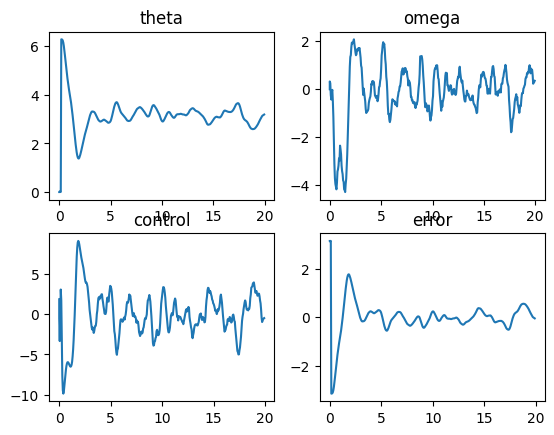

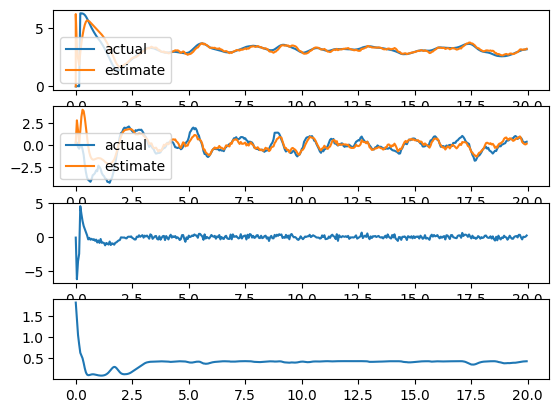

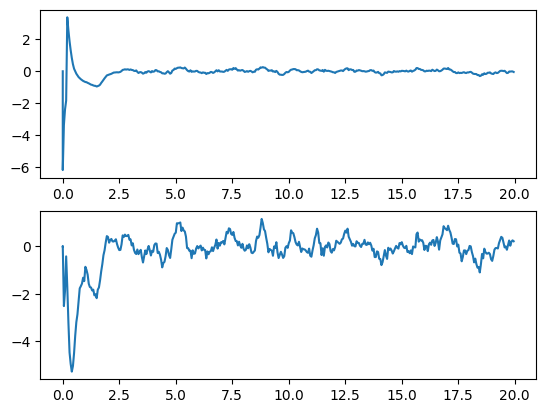

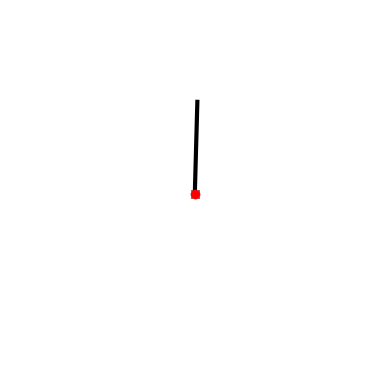

In [101]:
if __name__ == '__main__':
    main()
    

In [93]:
np.random.normal(0, 0,1)

array([0.])

In [16]:
help('np.hist')

No Python documentation found for 'np.hist'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

